## Lecture 35: Hard and soft constraints

Goal: to illustrate examples of constraints in optimization problems 

In [22]:
## MP 573 Lecture 35: Optimization Constraints
##
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd

font = {'weight' : 'normal',
        'size'   : 20}
np.set_printoptions(precision=2)

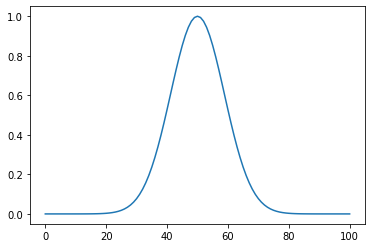

In [18]:
# Let's create a signal and its FT (ie: data, with noise)
N = 101
rmax = 40
r = np.linspace(-rmax,rmax,N)
x = 1.0*(np.exp(-(r*r/100.0)))

# Calculate a (discrete) Fourier transform, with some noise
xn = x + 0.04*rnd.normal(loc=0.0, scale=1.0, size=N)
d = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(xn)))/np.sqrt(N)

plt.plot(x);

## Unconstrained problem

Suppose we are reconstructing an image $\mathbf{x}$ from some data $\mathbf{d} = \mathbf{Ax}$ + Noise. In this case, $\mathbf{A}$ calculates a (discrete) Fourier transform. Our unconstrained optimization problem is:

$$\hat{\mathbf{x}} = \arg \min_{\mathbf{x}} \| \mathbf{Ax} - \mathbf{d} \|_2^2 $$

Importantly, even though our formulation is based on a matrix-vector multiplication where $\mathbf{A}$ is the DFT matrix, in practice we calculate $\mathbf{A x}$ by taking an FFT of $\mathbf{x}$. 

In [19]:
def func(x1):
    # Note that the matrix A is implemented efficiently using FFT
    d1 = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(x1)))/np.sqrt(N) 
    value = la.norm(d1-d)**2
    return value

`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 306, CG iterations: 2, optimality: 2.95e-07, constraint violation: 0.00e+00, execution time: 0.028 s.

Final value of the cost function:
3.76e-13

Error with respect to original noiseless image:
0.1402333109313676


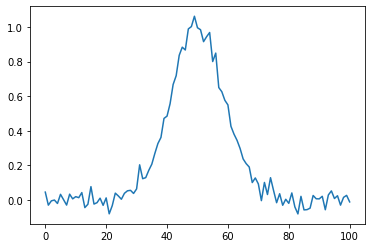

In [24]:
x0 = 0*xn
res = opt.minimize(func, x0, method='trust-constr', tol=1e-12, options={'gtol': 1e-6, 'disp': True})
plt.plot(res.x)

print('\nFinal value of the cost function:')
print(f"{res.fun:.3}")

print('\nError with respect to original noiseless image:')
print(la.norm(res.x-x)**2)

## Hard constraints

Further, suppose we know a priori which pixels within the image correspond to tissues (a total of $N_T$ pixels where the image intensity is different from zero), and which pixels correspond to air (a total of $N_A$ pixels where the image intensity is zero). The total number of pixels in the image is $N = N_T + N_A$. This constraint can be expressed as $\mathbf{Cx} = \mathbf{0}$, where $\mathbf{C}$ is a subsampling matrix that selects all the pixels in the air regions (and ignores the rest), and $\mathbf{0}$ is a zero-vector of the appropriate length $N_A$. 


Putting all these elements together, we have the following constrained formulation:
$$\hat{\mathbf{x}} = \arg \min_{\mathbf{x}} \| \mathbf{Ax} - \mathbf{d} \|_2^2 $$
$$\hbox{such that } \mathbf{Cx} = \mathbf{0}$$

In [5]:
from scipy.optimize import LinearConstraint
linear_constraint = LinearConstraint([[1, 2], [2, 1]], [-np.inf, 1], [1, 1])
C = np.identity(N)
C1 = C[0:20,:]
C2 = C[N-20:N,:]
C = np.concatenate((C1,C2),axis=0)


In [6]:
linear_constraint = LinearConstraint(C, np.zeros(40), np.zeros(40))

`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 306, CG iterations: 2, optimality: 7.64e-07, constraint violation: 0.00e+00, execution time: 0.043 s.

Final value of the cost function:
0.05518592501380918

Error with respect to original noiseless image:
0.10062866920214636


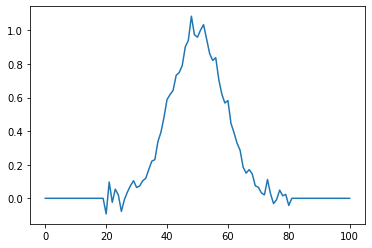

In [7]:
res = opt.minimize(func, x0, method='trust-constr', tol=1e-6, constraints=linear_constraint, options={'gtol': 1e-6, 'disp': True})
plt.plot(res.x)

print('\nFinal value of the cost function:')
print(res.fun)

print('\nError with respect to original noiseless image:')
print(la.norm(res.x-x)**2)

## Soft constraints

The example above applied hard constraints to an image reconstruction problem, and forced the pixel values to be zero in the image regions known to be air. A related approach to pose the reconstruction problem is to apply a soft constraint. In this case, instead of forcing the pixel values to be zero in the air regions, we can encourage small pixel values in this regions. For example, one might pose the reconstruction as follows: 

$$\hat{\mathbf{x}} = \arg \min_{\mathbf{x}} \| \mathbf{Ax} - \mathbf{d} \|_2^2 + \lambda \| \mathbf{Cx}\|_2^2 $$

for some value of $\lambda>0$. Note that the last term in our formulation will result in a  penalty for non-zero values of the image in the air region, but it will not penalize non-zero values in the tissue region. Further, this soft formulation will lead to higher penalty for higher values in the air region, whereas the hard constraint formulation above directly forbids any non-zero values, regardless of the specifics. 

In [8]:
def func2(x):
    lam = 5.0
    value = func(x) + lam*la.norm(C.dot(x))**2 
    return value

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 1224, CG iterations: 19, optimality: 4.40e-07, constraint violation: 0.00e+00, execution time: 0.13 s.

Final value of the cost function:
0.04598827084407967

Error with respect to original noiseless image:
0.10219985684556412


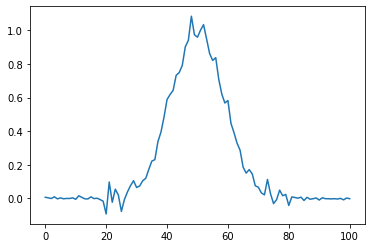

In [9]:
x0 = 0*xn
res = opt.minimize(func2, x0, method='trust-constr', tol=1e-12, options={'gtol': 1e-6, 'disp': True})
plt.plot(res.x)

print('\nFinal value of the cost function:')
print(res.fun)

print('\nError with respect to original noiseless image:')
print(la.norm(res.x-x)**2)